In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from julia import Main
from typing import Callable, Optional
from IPython.display import display, clear_output

dir_script = Path(os.getcwd())

## 代理モデル

代理モデルとして2次の多項式を用いる。

$$
\begin{aligned}
    \hat f(x) = b + \sum_{i=1}^N w_i x_i + \sum_{i \lt j} w_{ij} x_i x_j,
    \quad x \in \{0, 1\}^N
\end{aligned}
$$

このモデルは $x$ を $\phi(x) = [1, x_1, \dots, x_N, x_1 x_2, \dots, x_{N-1} x_N]$ に写像した上で、線形回帰を行うことに相当する。

$$
\begin{aligned}
    \hat f(x) = \phi(x)^\top w
\end{aligned}
$$

まず、$x \in \R^N, \phi(x) \in \R^P$ として、$N$ と $P$ の相互変換を行う関数を定義する。

In [46]:
def calc_P_from_N(N):
    return 1 + N + N * (N - 1) // 2

def calc_N_from_P(P):
    N = int((np.sqrt(8 * P - 7) - 1) // 2)
    return N

In [47]:
# test

N_list = np.arange(1, 100)
for N in N_list:
    P = calc_P_from_N(N)
    N = calc_N_from_P(P)
    assert N == N

ところで、モデルが変数として $x \in \{0, 1\}^N$ を取る2次の多項式であることから、二次形式で書き表すこともできる。

$$
\begin{aligned}
    \hat f(x) = x^\top Q x + b
\end{aligned}
$$

このQUBO行列 $Q$ と重みベクトル $w$ を相互変換する関数を定義しておく。ただし、変換時には、バイアス項 $b$ の情報が失われることに注意する。

In [48]:
def calc_Q_from_w(w: np.ndarray):
    P = w.shape[0]
    N = calc_N_from_P(P)
    Q = np.zeros((N, N), dtype=float)

    Q[np.diag_indices(N)] = w[1 : 1+N]
    Q[np.triu_indices(N, k=1)] = w[1+N : P]
    return Q

def calc_w_from_Q(Q: np.ndarray):
    N = Q.shape[0]
    P = calc_P_from_N(N)
    w = np.zeros((P,), dtype=float)

    w[1 : 1+N] = Q[np.diag_indices(N)]
    w[1+N : P] = Q[np.triu_indices(N, k=1)]
    return w

def visualize_Q(Q: np.ndarray, cmap='bwr'):
    cmap_range = np.abs(Q).max()
    plt.imshow(Q, cmap=cmap, interpolation='nearest', vmin=-cmap_range, vmax=cmap_range)
    plt.colorbar()
    plt.show()

In [49]:
# test

N = 16
P = calc_P_from_N(N)
Q = np.random.rand(N, N)
Q1 = np.triu(Q)
w1 = calc_w_from_Q(Q1)
Q2 = calc_Q_from_w(w1)

assert np.isclose(Q1, Q2).all()

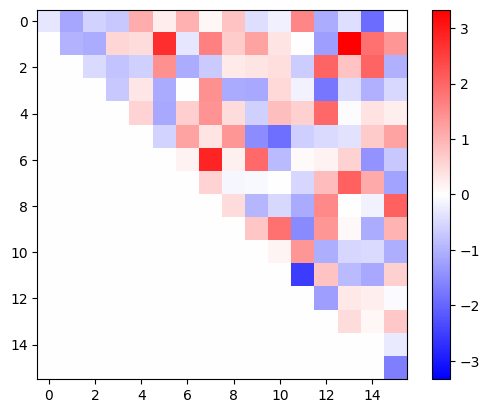

In [50]:
# test

N = 16
P = calc_P_from_N(N)
w = np.random.randn(P)
Q = calc_Q_from_w(w)

visualize_Q(Q)

以上を用いて、写像 $\phi(x)$ を実装する。

In [51]:
def calc_z_from_x(x: np.ndarray) -> np.ndarray:
    N = x.shape[0]
    P = calc_P_from_N(N)
    z = np.zeros(P, dtype=float)

    z[0 : 1]   = 1
    z[1 : 1+N] = x

    i, j       = np.triu_indices(N, k=1)
    z[1+N : P] = x[i] * x[j]

    return z

代理モデルを実装する。学習器は適当に `posterior_sampler: np.ndarray -> np.ndarray` とする。獲得関数はまだ実装しない。

In [52]:
class SurrogateModel:
    def __init__(self, num_features: int, posterior_sampler):
        N = num_features
        P = calc_P_from_N(N)

        w = np.zeros(P, dtype=float)
        self.params  = {'w': w}
        self.posterior_sampler = posterior_sampler

    def predict(self, x: np.ndarray) -> float:
        z = calc_z_from_x(x)
        return z @ self.params['w']

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)
        w = self.posterior_sampler(z_data, y_data)

        self.params['w'] = w

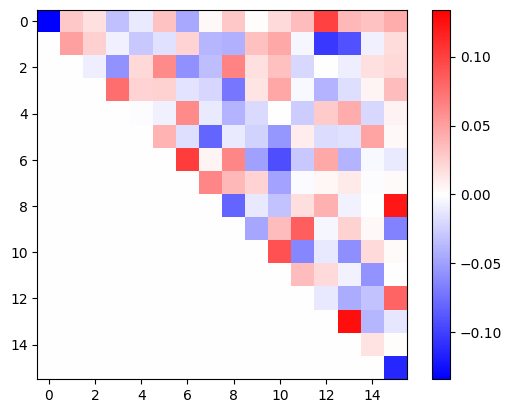

MSE: 0.0010631630879817837


In [53]:
# test

sample_lstsq = lambda z, y: np.linalg.lstsq(z, y, rcond=None)[0]

D = 256
N = 16

model = SurrogateModel(16, sample_lstsq)
x_data = np.random.choice([0, 1], size=(D, N))
Q_true = np.triu(np.random.normal(0, 1, size=(N, N)))
y_data = np.einsum('di,ij,dj->d', x_data, Q_true, x_data) + np.random.normal(0, 0.1, size=D)

model.fit(x_data, y_data)
Q_pred = calc_Q_from_w(model.params['w'])

visualize_Q(Q_true - Q_pred)

mse = np.mean((Q_true - Q_pred) ** 2)
print(f"MSE: {mse}")

## 獲得関数

獲得関数にはThompson抽出を用いる。これはパラメータの事後分布に従うサンプルを適用した代理モデルの予測器を獲得関数として用いるものである。すなわち

$$
\begin{aligned}
    &&
    \alpha(x)
    &= \hat f(x; \theta) = \phi(x)^\top \tilde w \\
    \text{where} &&
    w &\sim p(\tilde w | \mathcal D)
\end{aligned}
$$

まず、事後分布からサンプルを抽出する部分 $w \sim p(\tilde w | \mathcal D)$ を実装する。これには馬蹄事前分布を用いて得られる Gibbs サンプラーを用いる。詳細は `SparseBLR.ipynb` に記載されている。ここでは、`BOCS/Horseshoe.jl` 内の実装をインポートして用いる。

In [54]:
dir_bocs = dir_script / 'BOCS'
Main.include(str(dir_bocs / 'horseshoe.jl'))

<PyCall.jlwrap sample_horseshoe_posterior_old>

In [55]:
class HorseshoeSampler:
    def __init__(self, num_iter: int, show_progress: bool = False, use_julia: bool = True, old: bool = False):
        self.num_iter      = num_iter
        self.show_progress = show_progress
        self.use_julia     = use_julia
        self.old           = old

    def __call__(self, x_data: np.ndarray, y_data: np.ndarray):
        if self.use_julia:
            if self.old:
                return Main.sample_horseshoe_posterior_old(
                    x_data.astype(np.float64),
                    y_data.astype(np.float64),
                    self.num_iter,
                    self.show_progress
                )
            return Main.sample_horseshoe_posterior(
                x_data.astype(np.float64),
                y_data.astype(np.float64),
                self.num_iter,
                self.show_progress
            )
        else:
            raise NotImplementedError

獲得関数自体は代理モデルの `predict` そのものであるから、単なるエイリアスとして実装する。

In [56]:
class SurrogateModel:
    def initialize_params(self, P):
        w = np.zeros(P, dtype=float)
        self.params  = {'w': w}

    def __init__(self, num_features: int, posterior_sampler):
        N = num_features
        P = calc_P_from_N(N)

        self.initialize_params(P)
        self.posterior_sampler = posterior_sampler

    def predict(self, x: np.ndarray) -> float:
        z = calc_z_from_x(x)
        return z @ self.params['w']

    def fit(self, x_data: np.ndarray, y_data: np.ndarray):
        z_data = np.apply_along_axis(calc_z_from_x, 1, x_data)
        w = self.posterior_sampler(z_data, y_data)

        self.params['w'] = w

    def acquisition_function(self, x_data: np.ndarray) -> float:
        return self.predict(x_data)

獲得関数が実装できたので、あとはこれを最小化するために、適当な最適化手法を用いて探索を行う。ここではアニーリング法 (SA) を用いる。

In [57]:
def simulated_annealing_sampler(
    state_init: np.ndarray,
    energy_func: Callable,
    beta_schedule: Callable,
    proposer: Callable,
    t_all: int,
    show_progress: bool=False,
    seed: Optional[int]=None
):
    rng = np.random.default_rng(seed)
    state_current = state_init
    energy_current = energy_func(state_current)

    state_best  = state_current
    energy_best = energy_current

    iter_base = int(np.log10(t_all) + 1)

    for t in range(t_all):
        beta = beta_schedule(t, t_all)
        state_new    = proposer(state_current)
        energy_new   = energy_func(state_new)
        delta_energy = energy_new - energy_current

        if delta_energy < 0 or np.exp(-beta * delta_energy) > rng.uniform(0, 1):
            state_current  = state_new
            energy_current = energy_new

            if energy_current < energy_best:
                state_best  = state_current
                energy_best = energy_current

        if show_progress and (t % 100) == 0:
            print(f'iter {t:{iter_base}d}: {energy_best}')

    return state_best

class SimulatedAnnealingSampler:
    def __init__(self, proposer, beta_schedule, t_all, show_progress=False, seed=None):
        self.proposer      = proposer
        self.beta_schedule = beta_schedule
        self.t_all         = t_all

        self.show_progress = show_progress
        self.rng           = np.random.default_rng(seed)

        self.state = None

    def sample(self, state_init, energy_func):
        self.state = simulated_annealing_sampler(
            state_init,
            energy_func,
            self.beta_schedule,
            self.proposer,
            self.t_all,
            self.show_progress
        )

class ExponentialCooling:
    def __init__(self, beta_init=1e-3, beta_final=1e3):
        self.beta_init  = beta_init
        self.beta_final = beta_final

    def __call__(self, t: int, t_all: int) -> float:
        beta = self.beta_init * (self.beta_final / self.beta_init) ** (t / (t_all - 1))
        return beta

def propose_binary(state_current, seed=None):
    rng = np.random.default_rng(seed)
    N = len(state_current)
    idx = rng.integers(low=0, high=N)
    state_new = state_current.copy()
    state_new[idx] = 1 - state_new[idx]
    return state_new


In [58]:
# test

N = 16
D = 32

surrogate_model = SurrogateModel(
    num_features=N,
    posterior_sampler=HorseshoeSampler(
        num_iter     =1000,
        show_progress=True,
        use_julia    =True
    )
)

acquis_optimizer = SimulatedAnnealingSampler(
    proposer     =propose_binary,
    beta_schedule=ExponentialCooling(1e-3, 1e3),
    t_all        =2000,
    show_progress=True
)

x_data = np.random.choice([0, 1], size=(D, N))
Q_true = np.triu(np.random.normal(0, 1, size=(N, N)))
y_data = np.einsum('di,ij,dj->d', x_data, Q_true, x_data) + np.random.normal(0, 0.1, size=D)

print("-"*20)
print("training the surrogate model")
print("-"*20)
surrogate_model.fit(x_data, y_data)

print("-"*20)
print("sampling from the acquisition function")
print("-"*20)
acquis_optimizer.sample(np.random.choice([0, 1], size=N), surrogate_model.acquisition_function)

x_next = acquis_optimizer.state
y_next = np.einsum('i,ij,j->', x_next, Q_true, x_next) + np.random.normal(0, 0.1)

print(f"x_next: {x_next}")
print(f"y_next: {y_next}")

--------------------
training the surrogate model
--------------------
iter 100 | MSE: 0.08426362201105933
iter 200 | MSE: 0.19592954503741433
iter 300 | MSE: 0.05505150164096222
iter 400 | MSE: 0.04512368165442816
iter 500 | MSE: 0.03490567216521328
iter 600 | MSE: 0.053153617926144994
iter 700 | MSE: 0.07374418675651082
iter 800 | MSE: 0.007025123775848115
iter 900 | MSE: 0.0038124583594107728
iter 1000 | MSE: 0.011821033362259517
--------------------
sampling from the acquisition function
--------------------
iter    0: 1.9934067002312523
iter  100: -5.1284600073281235
iter  200: -5.1284600073281235
iter  300: -5.1284600073281235
iter  400: -9.75249181035328
iter  500: -9.75249181035328
iter  600: -9.75249181035328
iter  700: -9.75249181035328
iter  800: -11.092825905127166
iter  900: -11.568574851366
iter 1000: -11.568574851366
iter 1100: -12.293222614740408
iter 1200: -12.293222614740408
iter 1300: -12.293222614740408
iter 1400: -12.293222614740408
iter 1500: -12.293222614740408
i

## 反復を回す

以上実装された各要素を用いてベイズ最適化を実現する。まずはベイズ最適化全体を実装しよう。

In [83]:
def make_monotonically_decreasing(series):
    series_decreasing = series.copy()
    for i in range(1, len(series_decreasing)):
        series_decreasing[i] = min(series_decreasing[i], series_decreasing[i-1])
    return series_decreasing

def show_current_progress(fig, y_best_list, y_data, y_stop_criterion, N):
    clear_output(wait = True)
    if y_stop_criterion > -np.inf:
        y_best_list = np.array(y_best_list - y_stop_criterion) / N
        y_data = np.array(y_data - y_stop_criterion) / N
    plt.cla()
    plt.plot(range(len(y_best_list)), y_best_list, color='b')
    plt.scatter(range(len(y_data)), y_data, c='r', marker='x')
    plt.grid()
    plt.ylim(bottom=1e-2)
    plt.yscale('log')
    display(fig)

class BayesianOptimizer:
    def __init__(self, objective_function, surrogate_model, acquis_optimizer):
        self.objective_function = objective_function
        self.surrogate_model    = surrogate_model
        self.acquis_optimizer   = acquis_optimizer

    def sample(self, x_data_init: list[np.ndarray], y_data_init: list[float], num_iter: int, y_stop_criterion: float = -np.inf):
        x_data = x_data_init
        y_data = y_data_init
        y_best_list = make_monotonically_decreasing(y_data)

        fig = plt.figure()
        iter_base = int(np.log10(num_iter) + 1)

        while len(y_data) < num_iter:
            self.surrogate_model.fit(np.array(x_data), np.array(y_data))

            self.acquis_optimizer.sample(
                np.random.choice([0, 1], size=len(x_data[0])),
                self.surrogate_model.acquisition_function
            )

            x_next = self.acquis_optimizer.state
            y_next = self.objective_function(x_next)

            x_data.append(x_next)
            y_data.append(y_next)

            if y_next < y_best_list[-1]:
                y_best_list.append(y_next)
            else:
                y_best_list.append(y_best_list[-1])

            show_current_progress(fig, y_best_list, y_data, y_stop_criterion, N)

            # i = len(y_data)
            # print(f"iter {i+1:{iter_base}d} | {num_iter:{iter_base}d} | y_best: {y_best_list[-1]:.6f} | y_stop: {y_stop_criterion}")

            if np.isclose(y_best_list[-1], y_stop_criterion):
                break
            if (y_best_list[-1] - y_stop_criterion) / N <= 1e-3:
                break

        return x_data, y_data

In [84]:
D_init = 16
N = 16

def objective_function(x: np.ndarray) -> float:
    return np.einsum('i,ij,j->', x, Q_true, x)

surrogate_model = SurrogateModel(
    num_features=N,
    posterior_sampler=HorseshoeSampler(
        num_iter     =1000,
        show_progress=False
    )
)

acquis_optimizer = SimulatedAnnealingSampler(
    proposer     =propose_binary,
    beta_schedule=ExponentialCooling(1e-3, 1e3),
    t_all        =1000,
    show_progress=False
)

bayesian_optimizer = BayesianOptimizer(
    objective_function=objective_function,
    surrogate_model   =surrogate_model,
    acquis_optimizer  =acquis_optimizer
)

x_data = [np.random.choice([0, 1], size=(N)) for _ in range(D_init)]
y_data = [objective_function(x) for x in x_data]

実行前に、SAを用いて端的に近似解を求めておく。

In [85]:
sa_sampler = SimulatedAnnealingSampler(
    proposer     =propose_binary,
    beta_schedule=ExponentialCooling(1e-3, 1e3),
    t_all        =2000,
    show_progress=False
)

x_init = np.random.choice([0, 1], size=N)
sa_sampler.sample(x_init, objective_function)

x_sa = sa_sampler.state
y_sa = objective_function(x_sa)

print(f"x_sa: {x_sa}")
print(f"y_sa: {y_sa}")

x_sa: [1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0]
y_sa: -12.11403752513382


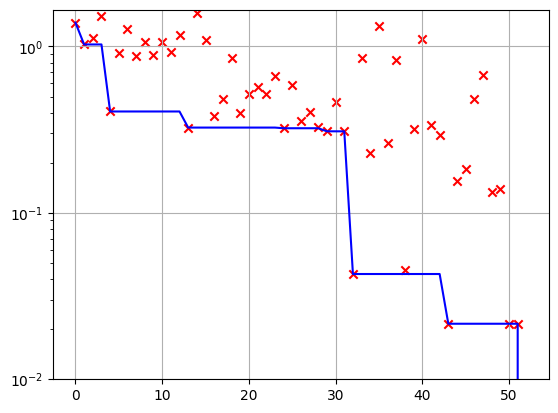

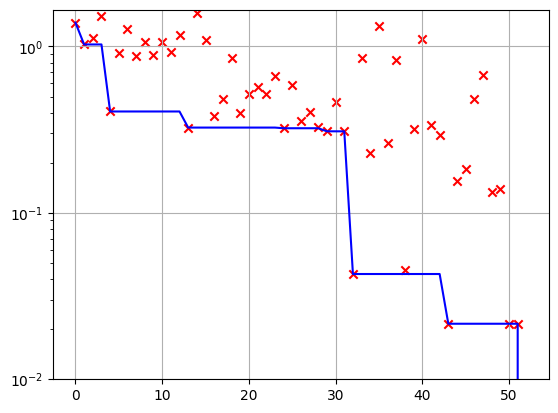

In [86]:
x_data_end, y_data_end = bayesian_optimizer.sample(x_data, y_data, num_iter=256, y_stop_criterion=y_sa)